In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("..")
sys.path.append("../..")

### First load in the data

In [3]:
from pathlib import Path
from collections import Counter
import random


import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import torch
import torch.utils.data


from src.data import DataPaths, Image, open_rgby

#### Load the training labels

In [5]:
kaggle_labels_df = pd.read_csv(DataPaths.TRAIN_LABELS)
# kaggle_labels_df = pd.read_csv("../data/train.csv")
hpa_labels_df = pd.read_csv(DataPaths.TRAIN_HPA_V18_LABELS)
all_labels_df = pd.read_csv(DataPaths.TRAIN_ALL_LABELS)
kaggle_labels_df['Target'] = [[int(i) for i in s.split()] for s in kaggle_labels_df['Target']]
hpa_labels_df['Target'] = [[int(i) for i in s.split()] for s in hpa_labels_df['Target']]
all_labels_df['Target'] = [[int(i) for i in s.split()] for s in all_labels_df['Target']]

In [6]:
kaggle_labels_df.head()

,Id,Target
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,"[16, 0]"
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,"[7, 1, 2, 0]"
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,[5]
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,[1]
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,[18]


In [27]:
hpa_labels_df.head()

,Id,Target
0,10580_1610_C1_1,"[13, 25, 0, 2, 21]"
1,10580_1610_C1_2,"[13, 25, 0, 2, 21]"
2,10580_1756_B1_1,"[13, 25, 0, 2, 21]"
3,10580_1756_B1_2,"[13, 25, 0, 2, 21]"
4,10580_1758_B1_1,"[13, 25, 0, 2, 21]"


In [29]:
all_labels_df.head()

,Id,Target
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,"[16, 0]"
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,"[7, 1, 2, 0]"
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,[5]
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,[1]
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,[18]


#### Helper function to help us see the proportion of each class

In [30]:
from src.data import single_class_counter

In [191]:
pprint(sorted(single_class_counter(kaggle_labels_df['Target'].values, smooth=0.1), key=lambda x: x[1], reverse=True))

[(0, 0.35373163719428147),
 (25, 0.262025914694183),
 (21, 0.17437674766649602),
 (2, 0.17130479303690285),
 (23, 0.15838682997912648),
 (7, 0.15557087156866609),
 (5, 0.14948603836004884),
 (4, 0.13658776731912883),
 (3, 0.130739238312788),
 (19, 0.12918356898113506),
 (1, 0.12469378913788351),
 (11, 0.12152337442400853),
 (14, 0.12099168996888662),
 (6, 0.11984955299121737),
 (18, 0.11776219920444253),
 (22, 0.1157929975188059),
 (12, 0.11354810759718012),
 (13, 0.11057461305186879),
 (16, 0.11043676893387422),
 (26, 0.1064589815288882),
 (24, 0.10634082942775),
 (17, 0.10413532353983697),
 (20, 0.10338702689929503),
 (8, 0.10104367689338743),
 (9, 0.10088614075853651),
 (10, 0.10055137647197827),
 (15, 0.1004135323539837),
 (27, 0.10021661218542005)]


In [185]:
pprint(sorted(single_class_counter(hpa_labels_df['Target'].values), key=lambda x: x[1], reverse=True))

[(25, 0.2553031165940893),
 (0, 0.24597173423522092),
 (21, 0.0878989932621286),
 (23, 0.06466253690934103),
 (2, 0.06352349493126319),
 (7, 0.05767933339758698),
 (5, 0.030009375191665716),
 (4, 0.02866881040208182),
 (6, 0.023805977341826497),
 (19, 0.0191884763999264),
 (22, 0.016884106859661265),
 (1, 0.01592906397034986),
 (3, 0.015490970901858392),
 (14, 0.014246786587342615),
 (12, 0.013537075816386433),
 (11, 0.009646809368182177),
 (18, 0.008683004617500942),
 (13, 0.008069674321612883),
 (16, 0.006659014641070349),
 (26, 0.003311983597795516),
 (20, 0.002330655124374622),
 (17, 0.00206779928327974),
 (8, 0.0014369452646520228),
 (10, 0.0013493266509537285),
 (9, 0.0013318029282140698),
 (27, 0.0010163759189002113),
 (24, 0.0009287573052019171),
 (15, 0.0003679981775328351)]


#### Lets see the class distribution when we do a Random Shuffle Split

In [40]:
from sklearn.model_selection import ShuffleSplit

In [41]:
train_idx, val_idx = list(ShuffleSplit(n_splits=1, test_size=0.1, random_state=42).split(X=all_labels_df))[0]

In [42]:
len(train_idx)

95110

In [43]:
len(val_idx)

10568

In [44]:
single_class_counter(all_labels_df['Target'].iloc[train_idx].values)

[(0, 0.24842271293375395),
 (1, 0.018576936558009113),
 (2, 0.06610450537895333),
 (3, 0.02021488851141848),
 (4, 0.03126937906117717),
 (5, 0.036068645690096796),
 (6, 0.0224527487934428),
 (7, 0.05680929655693063),
 (8, 0.0013346275175928173),
 (9, 0.0012200382862843431),
 (10, 0.00111893014101216),
 (11, 0.013400199520073337),
 (12, 0.013494567122327375),
 (13, 0.008910997869988406),
 (14, 0.01627167084580334),
 (15, 0.00037747040901615035),
 (16, 0.007758365013885518),
 (17, 0.0027299199223489445),
 (18, 0.011512847474992585),
 (19, 0.02218312707271698),
 (20, 0.0026692550351856345),
 (21, 0.08380517134460352),
 (22, 0.01660195745369247),
 (23, 0.06255897975140877),
 (24, 0.0025277036318045783),
 (25, 0.22660357518401683),
 (26, 0.004246542101431691),
 (27, 0.0007549408180323007)]

In [45]:
single_class_counter(all_labels_df['Target'].iloc[val_idx].values)

[(0, 0.24781059370658937),
 (1, 0.019085583137041735),
 (2, 0.06426284955003926),
 (3, 0.01993114694691067),
 (4, 0.029655130760403454),
 (5, 0.03545328259950474),
 (6, 0.02379658150631153),
 (7, 0.059008274445853715),
 (8, 0.0011475508848221296),
 (9, 0.0009663586398502144),
 (10, 0.0009663586398502144),
 (11, 0.01244186748807151),
 (12, 0.013951802862837471),
 (13, 0.008214048438726822),
 (14, 0.016790481367397476),
 (15, 0.0004227819049344688),
 (16, 0.008395240683698738),
 (17, 0.0024762940146161746),
 (18, 0.011173521773268105),
 (19, 0.02301141511143323),
 (20, 0.002536691429606813),
 (21, 0.08310684302711845),
 (22, 0.016065712387509815),
 (23, 0.06426284955003926),
 (24, 0.0032010629945038354),
 (25, 0.22636951138491274),
 (26, 0.0045902035392885185),
 (27, 0.000905961224859576)]

#### Now use multi-label stratified shuffle split

In [46]:
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit
import numpy as np

In [47]:
def make_one_hot(labels, n_classes=28):
    one_hots = []
    for label in labels:
        one_hot = np.zeros(n_classes)
        for label_idx in label:
            one_hot[label_idx] = 1
        one_hots.append(one_hot.astype(np.float32))
    return one_hots

In [48]:
labels_df = all_labels_df
labels_df.head()

,Id,Target
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,"[16, 0]"
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,"[7, 1, 2, 0]"
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,[5]
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,[1]
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,[18]


In [49]:
msss = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)

In [50]:
one_hots = make_one_hot(labels_df['Target'])

In [51]:
len(one_hots)

105678

In [52]:
train_idx, val_idx = list(msss.split(X=labels_df['Id'], y=one_hots))[0]

In [53]:
train_idx.shape

(95093,)

In [56]:
single_class_counter(labels_df['Target'].iloc[train_idx].values)

[(0, 0.2483644277349935),
 (1, 0.018629690268766128),
 (2, 0.06592147905591603),
 (3, 0.020186094772232665),
 (4, 0.03110787702383118),
 (5, 0.0360061717165592),
 (6, 0.022584709504847762),
 (7, 0.057027739036107236),
 (8, 0.0013138479574717522),
 (9, 0.0011925696844743597),
 (10, 0.0011049798206429096),
 (11, 0.013306921620547234),
 (12, 0.013542740484708831),
 (13, 0.008839838565143277),
 (14, 0.01632540308181567),
 (15, 0.000384047864491743),
 (16, 0.007822448608331818),
 (17, 0.002701810415108578),
 (18, 0.011481009843753158),
 (19, 0.022268038458687904),
 (20, 0.0026546466422762583),
 (21, 0.08373590982286634),
 (22, 0.01654774658231089),
 (23, 0.06272781786698468),
 (24, 0.0025940075057775624),
 (25, 0.22658150236829516),
 (26, 0.004278427964074681),
 (27, 0.000768095728983486)]

In [57]:
single_class_counter(labels_df['Target'].iloc[val_idx].values)

[(0, 0.24833272705226142),
 (1, 0.018612828907481508),
 (2, 0.06590275251606645),
 (3, 0.020189159694434338),
 (4, 0.031102218988723174),
 (5, 0.03601309567115315),
 (6, 0.02261428398205408),
 (7, 0.057051048866254395),
 (8, 0.0013338183581908573),
 (9, 0.0012125621438098702),
 (10, 0.0010913059294288831),
 (11, 0.013277555474718079),
 (12, 0.013520067903480053),
 (13, 0.008851703649812052),
 (14, 0.016308960834242756),
 (15, 0.0003637686431429611),
 (16, 0.007821025827573663),
 (17, 0.002728264823572208),
 (18, 0.011458712259003273),
 (19, 0.02225051533891112),
 (20, 0.0026676367163817145),
 (21, 0.08372741603007154),
 (22, 0.01655147326300473),
 (23, 0.06275009094216079),
 (24, 0.002607008609191221),
 (25, 0.22656723657087427),
 (26, 0.004304595610525039),
 (27, 0.0007881653934764157)]

#### Now we see that the data distribution is quite even, now lets use a weighted sampler

In [73]:
import torch
import torch.utils.data
from torch.utils.data import WeightedRandomSampler
from src.data import ProteinClassificationDataset
from functools import reduce
import math

In [329]:
def mean_proportion_class_weights(all_labels, smooth=0):
    all_weights = []
    label_proportions = single_class_counter(all_labels, smooth=smooth)
    weight_lookup = {label: 1 / prop for label, prop in label_proportions}
    for labels in all_labels:
        weights = np.array([weight_lookup[l] for l in labels]).mean()
        all_weights.append(weights)
    return all_weights

def mean_proportion_squared_class_weights(all_labels, smooth=0, power=1.5):
    all_weights = []
    label_proportions = single_class_counter(all_labels, smooth=smooth)
    weight_lookup = {label: (1 / prop) ** power for label, prop in label_proportions}
    for labels in all_labels:
        weights = np.array([weight_lookup[l] for l in labels]).mean()
        all_weights.append(weights)
    return all_weights

In [330]:
# labels_df = kaggle_labels_df
# train_paths = np.array(list(DataPaths.TRAIN_COMBINED_IMAGES.glob("*")))

# labels_df = hpa_labels_df
# train_paths = np.array(list(DataPaths.TRAIN_COMBINED_HPA_V18_IMAGES.glob("*")))

labels_df = all_labels_df
train_paths = np.array(sorted(list(DataPaths.TRAIN_ALL_COMBINED_IMAGES.glob("*")), key=lambda p: p.stem))

In [331]:
labels_df = labels_df.sort_values(["Id"], ascending=[True])
labels = labels_df['Target'].values
train_labels_one_hot = make_one_hot(labels_df['Target'])
assert np.all(np.array([p.stem for p in train_paths]) == labels_df["Id"])

train_idx, val_idx = list(msss.split(X=labels_df['Id'], y=train_labels_one_hot))[0]
# weights = np.array(mean_proportion_class_weights(labels[train_idx]))
weights = np.array(mean_proportion_squared_class_weights(labels[train_idx], smooth=0, power=1))
assert np.all(np.array([p.stem for p in train_paths]) == labels_df["Id"])

In [332]:
max(weights)

1307.8922064777328

In [333]:
min(weights)

4.026341489881179

In [334]:
# sampler = WeightedRandomSampler(weights, num_samples=len(weights))
sampler = WeightedRandomSampler(weights, num_samples=len(weights))

In [335]:
ds = ProteinClassificationDataset(train_paths[train_idx], labels=make_one_hot(labels[train_idx]))
dl = torch.utils.data.DataLoader(ds, batch_size=64, sampler=sampler, collate_fn=ds.collate_fn)
no_sampler_dl = torch.utils.data.DataLoader(ds, batch_size=64, collate_fn=ds.collate_fn)

In [336]:
len(dl.dataset)

95125

In [337]:
# cnt = Counter()
# for x, y in tqdm_notebook(no_sampler_dl):
#     for l in np.where(y['label'].data.numpy() == 1)[1]:
#         cnt[l] += 1

In [338]:
# cnt

In [339]:
label_cnt = Counter()
name_cnt = Counter()
n_samples = 100000
for idx in np.random.choice(train_idx, n_samples, p=weights/weights.sum()):
    r = labels_df.iloc[idx]
    labels = r['Target']
    for l in labels:
        label_cnt[l] += 1
    name_cnt[r['Id']] += 1
    
# for x, y in tqdm_notebook(dl):
#     for l in np.where(y['label'].data.numpy() == 1)[1]:
#         label_cnt[l] += 1
#     for n in y['name']:
#         name_cnt[n] += 1

In [340]:
from pprint import pprint
pprint(sorted({k: v/sum(label_cnt.values()) for k, v in label_cnt.items()}.items()))

[(0, 0.11371778716675314),
 (1, 0.02472018382625454),
 (2, 0.04407876856175722),
 (3, 0.030427692535764585),
 (4, 0.03521483458107874),
 (5, 0.03162602228646258),
 (6, 0.03506658760161095),
 (7, 0.03689496701504707),
 (8, 0.031700145776196474),
 (9, 0.03394238134064685),
 (10, 0.029254070614977888),
 (11, 0.028488127887727623),
 (12, 0.025331702616559187),
 (13, 0.022348232154769845),
 (14, 0.03260198156795888),
 (15, 0.015077953203370149),
 (16, 0.02594939836434166),
 (17, 0.016653077360215453),
 (18, 0.02880315271909668),
 (19, 0.02812368739653596),
 (20, 0.026888295900971016),
 (21, 0.05499962938255133),
 (22, 0.02727126726459615),
 (23, 0.03873570034343884),
 (24, 0.022805327008128876),
 (25, 0.11857287574432337),
 (26, 0.020563091443678502),
 (27, 0.020143058335186422)]


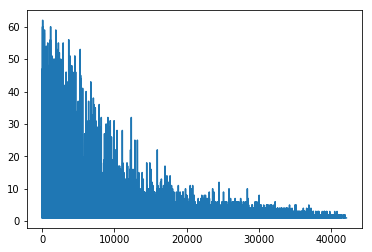

In [341]:
plt.plot(name_cnt.values())

In [353]:
from functools import partial
foo = partial(partial(partial(lambda x, y, z: x+y+z, x=3), y=4), z=5)

In [373]:
x = dict(a=[1,2,3], b=[4, 5, 6])

In [374]:
(k, v) = zip(*(x.items()))

In [375]:
k

('a', 'b')

In [376]:
vSD

([1, 2, 3], [4, 5, 6])

In [381]:
for sample_values in list(zip(*v)):
    for name, value in zip(k, sample_values):
        print(name, value)

a 1
b 4
a 2
b 5
a 3
b 6
